In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch

device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)


# Load the data and some processing

## Custom Dataset Implementation

In [ ]:
from torch.utils.data import Dataset
from torchtext.vocab import GloVe
import torchtext
from torchtext.functional import to_tensor
from nltk import word_tokenize, download
from random import sample

download('punkt')

embed_size = 50
embedder = GloVe(name="twitter.27B", dim=embed_size)

def tokenize(quote, word_embedder):
  tokens = word_tokenize(quote)
  tokens = torch.stack([word_embedder[word] for word in tokens]).to(device)
  return tokens

def swap_keys_values(d):
    return {value: key for key, value in d.items()}

class QuotesDateset(Dataset):

    data = []
    category_to_idx = dict()
    idx_to_category = dict()

    def _load_data(self, path_to_data):

        for path_to_category in path_to_data.glob('*.txt'):
            category = path_to_category.stem
            with path_to_category.open("r") as file_handler:
                data_from_file = file_handler.read().splitlines()
            self.data.extend([[quote.lower(), category] for quote in data_from_file])

        categories = set([category for _, category in self.data])
        self.category_to_idx = {category: index for index, category in enumerate(categories)}
        self.idx_to_category = swap_keys_values(self.category_to_idx)

    def tokenized(self, word_embedder):
        self.quotes = []
        self.categories = []
        tokenized_quotes = dict()
        number_of_multiple_quotes = 0
        for quote, category in self.data:
          category_index = self.category_to_idx[category]
          if quote not in tokenized_quotes:
            tokenized_quotes[quote] = len(tokenized_quotes)
            one_hot_category = torch.zeros(len(self.category_to_idx)).to(device)
            one_hot_category[category_index] = 1
            self.quotes.append(tokenize(quote, word_embedder))
            self.categories.append(one_hot_category)
          else:
            number_of_multiple_quotes += 1
            self.categories[tokenized_quotes[quote]][category_index] = 1
        self.tokenized_quotes = tokenized_quotes
        self.index_tokenized_quotes = swap_keys_values(self.tokenized_quotes)
        print(f"Number of quotes with multiple categories / total data: {number_of_multiple_quotes}/{len(self.data)}")

    def __init__(self, path_to_data):
        self._load_data(path_to_data)

    def __len__(self):
        return len(self.quotes)

    def __getitem__(self, idx):
        return self.quotes[idx], self.categories[idx]

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        display_str = ""

        for quote, category in sample(self.data, 4):
            display_str += f"{category}: {quote}\n"

        display_str += f"\nThis dataset has {len(self.quotes)} quotes"
        return display_str



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
.vector_cache/glove.twitter.27B.zip: 1.52GB [07:10, 3.53MB/s]                            
100%|█████████▉| 1193513/1193514 [00:31<00:00, 37423.07it/s]


## Load the dataset

In [ ]:
from pathlib import Path

path_to_data = Path('drive/MyDrive/quotes')
dataset = QuotesDateset(path_to_data)

dataset.tokenized(embedder)


print(dataset)

Number of quotes with multiple categories / total data: 12564/76511
happiness: “the universe doesn't give you what you want in your mind; it gives you what you demand with your actions.”
inspirational: “even if you have been through a painful past, do not dwell on that. what matters is that you are still alive. bank on that and make your life count.”
inspirational: “because when we give too many fucks, when we choose to give a fuck about everything, then we feel as though we are perpetually entitled to feel comfortable and happy at all times, that’s when life fucks us.”
science: “no one will protect what they don't care about; and no one will care about what they have never experiened”

This dataset has 63947 quotes


In [ ]:
# Check if len of quotes == categories
assert len(dataset.quotes) == len(dataset.categories), "Quotes should equal to categories"

## Splitting

In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)
    truncated_sequences = [seq[:1000] if seq.size(0) > 1000 else seq for seq in sequences]
    padded_sequences = pad_sequence(truncated_sequences, batch_first=True)
    return padded_sequences, torch.stack(labels)

batch_size = 64

# Split the dataset into training, validation, and test sets
num_train = int(len(dataset) * 0.8)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset)  - num_train - num_val

train_data, val_data ,test_data = random_split(dataset, [num_train, num_val, num_test])
# Create a DataLoader for each set
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)


# EDA

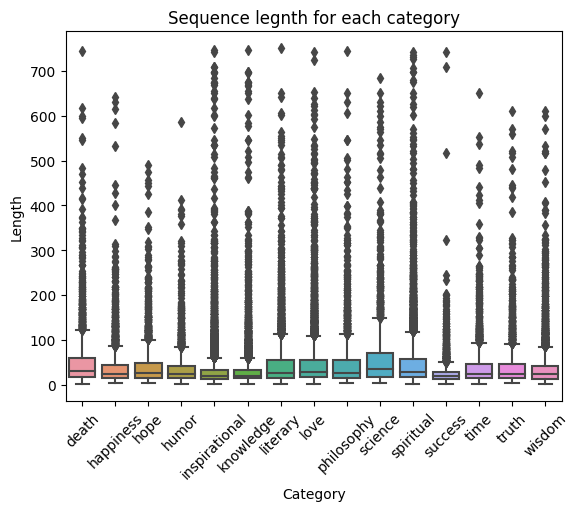

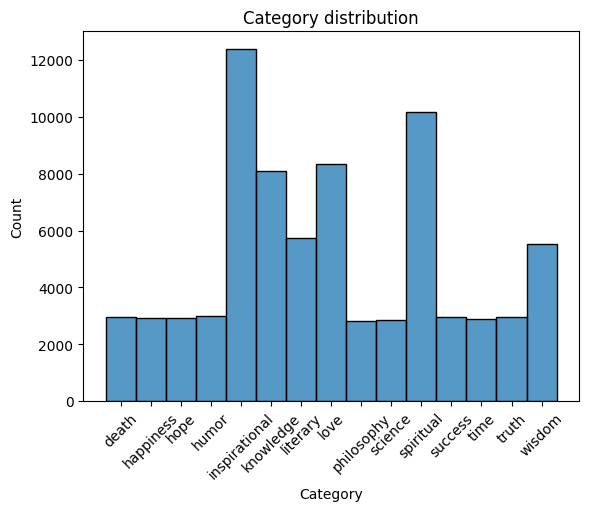

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

quote_length = [(len(quote.split()), category) for quote, category in dataset.data]
lengths, categories = zip(*quote_length)

df = pd.DataFrame({'Category': categories, 'Length': lengths})
df.dropna(inplace=True)
sns.boxplot(x=df['Category'], y=df['Length'])
plt.xticks(rotation=45)
plt.title("Sequence legnth for each category")

plt.show()
sns.histplot(df['Category'])
plt.xticks(rotation=45)
plt.title("Category distribution")
plt.show()

## Count unique words in each set

In [ ]:
def find_vocab(sentences):
    return {word for sentence in sentences for word in sentence.split()}

def find_vocab_of_subset(data_subset, data_original):
    quotes_subset = [data_original.index_tokenized_quotes[index] for index in data_subset.indices]
    return find_vocab(quotes_subset)

def create_vocab_dict(data_splits, dataset):
    vocabs = {}
    vocabs['original'] = find_vocab([quote for quote, _ in dataset.data])
    for split_name, data_split in data_splits.items():
        vocabs[split_name] = find_vocab_of_subset(data_split, dataset)
    return vocabs

def create_out_of_vocab_dict(vocabs):
    out_of_vocab = {subsetA: {subsetB: len(vocabs[subsetA] - vocabs[subsetB]) for subsetB in vocabs} for subsetA in vocabs}
    return out_of_vocab

data_splits = {
    'train': train_data,
    'val' : val_data,
    'test': test_data
}

vocabs = create_vocab_dict(data_splits, dataset)
out_of_vocab = create_out_of_vocab_dict(vocabs)
out_of_vocab_df = pd.DataFrame(out_of_vocab)
out_of_vocab_df


,original,train,val,test
original,0,0,0,0
train,15848,0,8116,8102
val,97024,89292,0,17234
test,97290,89544,17500,0


# Model

In [ ]:
categories = dataset.category_to_idx.keys()
joined_categories = ' '.join(categories)
categories_embedding = tokenize(joined_categories, embedder)

In [ ]:
import torch
import torch.nn as nn

## Implementation of the Models

### Componenets

In [ ]:
def batch_dot_product(a, b):
  return (a * b).sum(dim = -1)

#### FeedForwardNN

In [ ]:
class FeedForwardNN(nn.Module):
  def __init__(self, hidden_size , inter_size):
    super(FeedForwardNN, self).__init__()
    self.linear1 = nn.Linear(hidden_size, inter_size)
    self.activation = nn.GELU()
    self.linear2 = nn.Linear(inter_size, hidden_size)

  def forward(self, input):
    output = self.linear1(input)
    output = self.activation(output)
    output = self.linear2(output)
    return output



#### Attention Block

In [ ]:
class AttentionBlock(nn.Module):
  def __init__(self, config):
    super(AttentionBlock, self).__init__()
    self.attention = nn.MultiheadAttention(
        batch_first=True,
        embed_dim=config.embed_size,
        num_heads=config.num_heads,
        vdim=config.context_size,
        kdim=config.context_size,
        dropout=config.dropout
    )
    self.ln = nn.LayerNorm(config.embed_size)
    self.ffn = FeedForwardNN(config.embed_size, config.hidden_size)

  def forward(self, query, context):
    attention_output, _  = self.attention(query, context, context)
    output = self.ln(attention_output + query)
    output = self.ffn(output)
    return attention_output + output


### Label Induced Cross Attention

In [ ]:
class SequenceCrossAttention(nn.Module):
    def __init__(self, config):
        super(SequenceCrossAttention, self).__init__()


        self.sequence_layer = nn.LSTM(
            input_size=config.embed_size,
            hidden_size=config.hidden_dim,
            num_layers=config.num_layers,
            bidirectional=config.bidirectional,
            bias=config.bias,
            dropout=config.dropout
        )

        self.ln_sequence = nn.LayerNorm(config.sequence_size)

        self.self_attention = AttentionBlock(config.self_attention_config)
        self.cross_label_attention = AttentionBlock(config.cross_label_attention_config)
        self.labels_induced_attention = AttentionBlock(config.labels_induced_attention_config)
        self.label_embeddings_induced = nn.Parameter(config.label_embeddings)
        self.label_embeddings_cross = nn.Parameter(config.label_embeddings)
        self.sigmoid = nn.Sigmoid()
    def forward(self, input):
        batch_size = input.size(0)
        batched_label_embeddings_induced = self.label_embeddings_induced.unsqueeze(0).expand(batch_size, -1, -1)
        batched_label_embeddings_cross = self.label_embeddings_cross.unsqueeze(0).expand(batch_size, -1, -1)
        sequence_out, _ = self.sequence_layer(input)
        sequence_out = self.ln_sequence(sequence_out)
        output = self.self_attention(sequence_out, sequence_out)
        output = self.labels_induced_attention(output, batched_label_embeddings_induced)
        output = self.cross_label_attention(batched_label_embeddings_cross, output)
        output = batch_dot_product(batched_label_embeddings_cross, output)
        output = self.sigmoid(output)
        return output


## Main Model

In [ ]:
class AttentionConfig:

    def __init__(self, embed_size=512, num_heads=8,
                 context_size=512,hidden_size=2048, dropout=0.1):
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.dropout = dropout

    def to_dict(self):
        return {
            'embed_size': self.embed_size,
            'num_heads': self.num_heads,
            'context_size': self.context_size,
            'hidden_size': self.hidden_size,
            'dropout': self.dropout
        }

In [ ]:
class ModelConfig:
    def __init__(self, embed_size=512, hidden_dim=256, num_layers=1,
                 bidirectional=False, bias=True, dropout=0.1,
                 label_embeddings=None, self_attention_config=None, cross_label_attention_config=None,
                 labels_induced_attention_config=None):

        self.embed_size = embed_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.bias = bias
        self.dropout = dropout
        self.label_embeddings = label_embeddings
        self.self_attention_config = self_attention_config
        self.cross_label_attention_config = cross_label_attention_config
        self.sequence_size = 2* hidden_dim if bidirectional else hidden_dim
        self.labels_induced_attention_config = labels_induced_attention_config

    def to_dict(self):
        return {
            'embed_size': self.embed_size,
            'hidden_dim': self.hidden_dim,
            'num_layers': self.num_layers,
            'bidirectional': self.bidirectional,
            'bias': self.bias,
            'dropout': self.dropout,
            'label_embeddings': self.label_embeddings,
            'self_attention_config': self.self_attention_config,
            'cross_label_attention_config': self.cross_label_attention_config,
            'labels_induced_attention_config': self.labels_induced_attention_config
        }


In [ ]:
num_classes = len(dataset.category_to_idx)
hidden_dim = embed_size // 2
num_layers = 1
bidirectional = True
bi_factor = 2 if bidirectional else 1
sequence_size = bi_factor * hidden_dim

self_attention_config = AttentionConfig( embed_size=sequence_size, num_heads=2,
                                          context_size=sequence_size,hidden_size=hidden_dim, dropout=0.3)

labels_induced_attention_config = AttentionConfig( embed_size=sequence_size, num_heads=2,
                                          context_size=embed_size,hidden_size=embed_size // 2, dropout=0.3)

cross_label_attention_config = AttentionConfig( embed_size=embed_size, num_heads=1,
                                          context_size=sequence_size,hidden_size=num_classes // 2, dropout=0.3)



model_config = ModelConfig(
    embed_size = embed_size, hidden_dim = hidden_dim,
    num_layers = num_layers, bidirectional = bidirectional,
    label_embeddings = categories_embedding, dropout = 0.3,
    self_attention_config = self_attention_config,
    labels_induced_attention_config = labels_induced_attention_config,
    cross_label_attention_config = cross_label_attention_config
)

model = SequenceCrossAttention(model_config).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {count_parameters(model)}")

Number of parameters: 53807


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
model

SequenceCrossAttention(
  (sequence_layer): LSTM(50, 25, dropout=0.3, bidirectional=True)
  (ln_sequence): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  (self_attention): AttentionBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
    (ln): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (ffn): FeedForwardNN(
      (linear1): Linear(in_features=50, out_features=25, bias=True)
      (activation): GELU(approximate='none')
      (linear2): Linear(in_features=25, out_features=50, bias=True)
    )
  )
  (cross_label_attention): AttentionBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
    (ln): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (ffn): FeedForwardNN(
      (linear1): Linear(in_features=50, out_features=7, bias=True)
      (activation): GELU(approximate='none')
      

# Train and test model

### Evaluation metric

In [ ]:
%%capture
!pip install torcheval

NotImplementedError: ignored

In [ ]:
from torcheval.metrics import TopKMultilabelAccuracy,MultilabelAUPRC

def prob_to_onehot(prob_output, thresholds):
    expanded_thresholds = np.expand_dims(thresholds, axis=0)
    expanded_thresholds = np.broadcast_to(expanded_thresholds, prob_output.shape)
    output = (prob_output > expanded_thresholds).astype(int)
    for index, sample in enumerate(output):
           if sum(sample) == 0.0:
            output[index][np.argmax(prob_output[index])] = 1.0
    return output

def compute_metric_for_thresholds(outputs, targets,metric, thresholds):
    predicted = prob_to_onehot(outputs, thresholds)
    score = metric(targets.cpu().numpy(), predicted.cpu().numpy())
    return score

def onehot_to_labels(onehot,idx_to_category):
    indices = torch.nonzero(onehot == 1)
    batch_labels = []
    for i in range(onehot.size(0)):
        sample_labels = [idx_to_category[index[1].item()] for index in indices if index[0] == i]
        batch_labels.append(sample_labels)

    return batch_labels

aurpc = MultilabelAUPRC(num_labels=len(dataset.category_to_idx), average='macro').to(device)
def eval_metric(outputs, targets):
    aurpc.update(outputs, targets)
    score = aurpc.compute()
    aurpc.reset()
    return score.mean()

number_of_predictions = 2
def topKPrediction(outputs, k=number_of_predictions, idx_to_category=dataset.idx_to_category):
  kPredictions = torch.argsort(outputs, dim = 1)[:, :k]
  return [[idx_to_category[idx.item()] for idx in row] for row in kPredictions]



In [ ]:
def find_optimal_threshold(outputs, targets, metric):
  assert outputs.size(1) == targets.size(1), "Num of classes of targets and outputs are not equal"
  num_classes = outputs.size(1)
  optimal_thresholds = [0 for _ in range(num_classes)]

  for label in range(num_classes):
    class_logits = outputs[:, label]
    class_targets = targets[:, label]
    interval_width = 0.05
    best_score = 0

    for threshold in np.linspace(0,1,int(1/interval_width)+1):
      class_preds = (class_logits > threshold).int()
      score = metric(class_targets.cpu().numpy(), class_preds.cpu().numpy())
      if score > best_score:
        best_score = score
        optimal_thresholds[label] = threshold

  return optimal_thresholds







### Utilies functions for training and testing

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion,  metric):
    model.train()
    total_loss = 0
    start_time = time.time()
    average_metric = 0
    for batch_num, (inputs, targets) in enumerate(loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          average_metric += metric(outputs, targets)
    elapsed_time = time.time() - start_time
    average_metric /= len(loader)
    avg_loss = total_loss / len(loader)
    return avg_loss, average_metric, elapsed_time

def evaluate(model, loader, criterion, metric):
    model.eval()
    total_loss = 0
    all_outputs, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(targets)
    all_outputs, all_targets = torch.cat(all_outputs, dim=0), torch.cat(all_targets, dim=0)
    eval_metric = metric(all_outputs, all_targets)
    avg_loss = total_loss / len(loader)
    return avg_loss, eval_metric, all_outputs, all_targets

def display_metrics(train_loss, train_improvement, val_loss, val_improvement, train_eval_metric, val_eval_metric, METRIC_NAME):
    data = {
        'train': [f"{train_loss:.5f}", f"{train_improvement:.5f}", f"{train_eval_metric:.5f}"],
        'val': [f"{val_loss:.5f}", f"{val_improvement:.5f}", f"{val_eval_metric:.5f}"]
    }

    df = pd.DataFrame(data, index=['loss', 'improvement', METRIC_NAME + ' Score'])
    display(df)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def step(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"Early Stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop

## Main Train Loop

In [ ]:
import time
import torch.optim as optim
import pandas as pd
from IPython.display import display, clear_output

def train_model(model, train_loader, val_loader, train_config):

    criterion = train_config['criterion']
    optimizer = train_config['optimizer']
    num_epochs = train_config['num_epochs']
    metric = train_config['metric']
    metric_name = train_config['metric_name']
    refresh_period = train_config.get('refresh_period', 10)

    train_losses = []
    val_losses = []
    train_metric = []
    val_metric = []
    total_batches = len(train_loader)
    early_stopping = EarlyStopping(patience=int(num_epochs*0.1), delta=0.00001)

    for epoch in range(num_epochs):
        if epoch % refresh_period == 0:
            clear_output(wait=True)

        train_loss, train_eval_metric, elapsed_time = train_one_epoch(model, train_loader, optimizer, criterion, metric)
        val_loss, val_eval_metric, _, _ = evaluate(model, val_loader, criterion, metric)



        print(f"Epoch: {epoch+1}, Elapsed Time: {elapsed_time:.3f}s")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        train_improvement = train_losses[-2] - train_loss if epoch > 0 else 0
        val_improvement = val_losses[-2] - val_loss if epoch > 0 else 0
        display_metrics(train_loss, train_improvement,
                        val_loss, val_improvement,
                        train_eval_metric, val_eval_metric, metric_name)
        train_metric.append(train_eval_metric.item())
        val_metric.append(val_eval_metric.item())

        if early_stopping.step(val_loss):
            print("Early stopping triggered.")
            break

    plot_training_results(train_metric, val_metric, train_losses,val_losses, train_config['metric_name'])

## Plottings the training results function


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_results(train_metric, val_metric, train_losses, val_losses, METRIC_NAME):
    sns.set_theme(style="whitegrid")

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting Metric
    axs[0].plot(train_metric, label="Train", linewidth=1.0)
    axs[0].plot(val_metric, label="Validation", linewidth=1.0)
    metric_train_val_corr = np.corrcoef(train_metric, val_metric)[0, 1]
    axs[0].set_title(f"{METRIC_NAME}: TRAIN vs VAL, corr: {metric_train_val_corr:.5f}")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel(METRIC_NAME)
    axs[0].legend()

    # Plotting Losses
    axs[1].plot(train_losses, label="Train", linewidth=1.0 )
    axs[1].plot(val_losses, label="Validation", linewidth=2.5)
    loss_train_val_corr = np.corrcoef(train_losses, val_losses)[0, 1]
    axs[1].set_title(f"Loss: TRAIN vs VAL, corr: {loss_train_val_corr:.5f}")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()



## Train the model

In [ ]:
train_config = {
    'criterion': torch.nn.BCELoss(),
    'optimizer': optim.AdamW(model.parameters(), lr=0.005),
    'num_epochs': 300,
    'metric': eval_metric,
    'metric_name': 'AURPC',
    'refresh_period': 10,
    'batch_size': batch_size
}

train_model(model, train_loader, val_loader, train_config)

Epoch: 21, Elapsed Time: 23.951s


,train,val
loss,0.18206,0.18991
improvement,-0.00055,-0.00001
AURPC Score,0.57099,0.48493


Early Stopping counter: 11 out of 30


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, f1_score
_,_, val_outputs, val_targets = evaluate(model, val_loader, torch.nn.BCELoss(), eval_metric)
best_thresholds = find_optimal_threshold(val_outputs, val_targets, f1_score)

# Evaluation

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, f1_score
from functools import partial

micro_f1 = partial(f1_score, average='micro')

test_loss, test_metric, outputs, targets =  evaluate(model, test_loader, torch.nn.BCELoss(), eval_metric)
print(f"Test loss: {test_loss:.5f}")
print(f"Test {train_config['metric_name']}: {test_metric:.5f}")

y_pred = prob_to_onehot(outputs.cpu().numpy(), best_thresholds)
y_true = targets.cpu().numpy()

confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

metrics = { 'accuracy', 'precision', 'recall', 'f1'}
print(f"Test micro F1: {micro_f1(y_true, y_pred):.3f}")

metrics_per_index = dict()

for index, matrix in enumerate(confusion_matrix):
  category = dataset.idx_to_category[index]
  metrics_per_index[category] = dict()
  TN, FP, FN, TP = matrix.ravel()
  metrics_per_index[category]['accuracy'] = (TP + TN) /(TP + TN + FP + FN+ 1e-10)
  metrics_per_index[category]['precision'] = TP / (TP + FP + 1e-10)
  metrics_per_index[category]['recall'] = TP/ (TP + FN + 1e-10)
  metrics_per_index[category]['f1'] = 2 * TP / (2*TP + FP +FN + 1e-10)



metrics_dataframe = pd.DataFrame(metrics_per_index).round(2)
display(metrics_dataframe)

Test loss: 0.19335
Test AURPC: 0.47129
Test micro F1: 0.498


,spiritual,philosophy,love,inspirational,time,happiness,success,hope,literary,science,truth,wisdom,knowledge,humor,death
accuracy,0.89,0.92,0.87,0.73,0.95,0.97,0.94,0.96,0.93,0.96,0.96,0.92,0.85,0.93,0.95
precision,0.63,0.19,0.51,0.38,0.47,0.69,0.41,0.66,0.56,0.60,0.50,0.65,0.39,0.26,0.56
recall,0.66,0.26,0.65,0.71,0.56,0.52,0.44,0.39,0.54,0.43,0.41,0.34,0.37,0.39,0.58
f1,0.65,0.22,0.57,0.50,0.51,0.59,0.42,0.49,0.55,0.50,0.45,0.45,0.38,0.32,0.57


### Example

In [ ]:
sample = "I discovered life sometimes has a way of giving you what you need, but not in the form you expected."
sampled_tokenized = tokenize(sample, embedder).unsqueeze(0)
predictions = model(sampled_tokenized)
print(f" The quote '{sample}' \n is tagged as {', '.join(topKPrediction(predictions,2)[0])}")


 The quote 'I discovered life sometimes has a way of giving you what you need, but not in the form you expected.' 
 is tagged as time, success
